# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


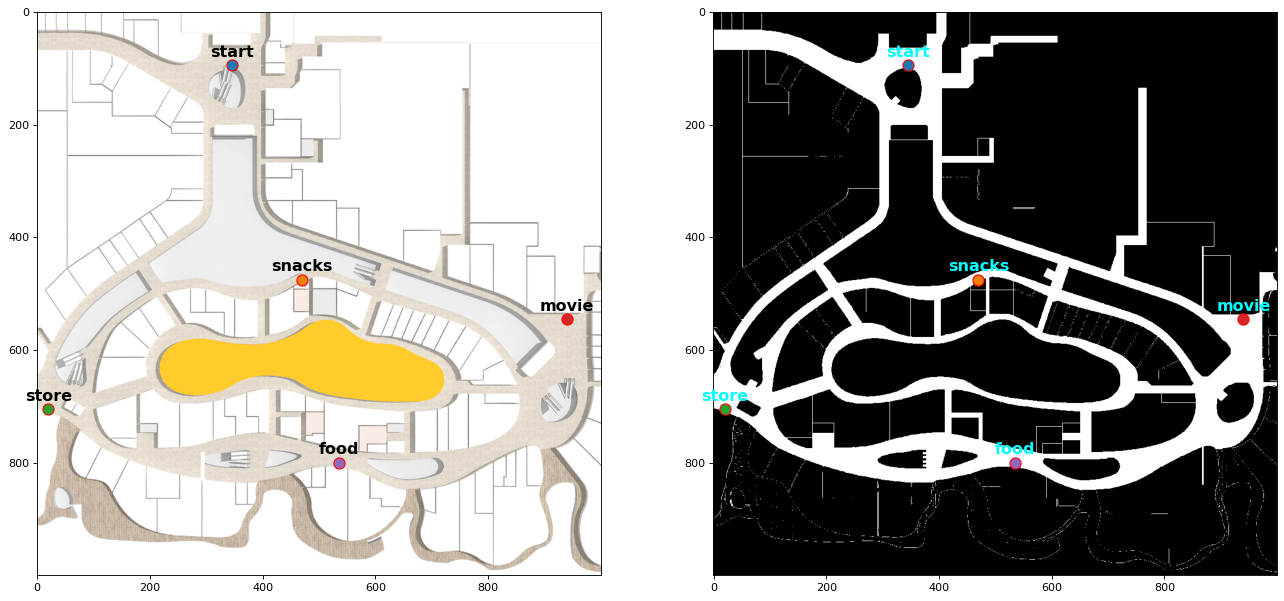

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

Implement A*

Total Travelled Distance: 140.882 m
Total Run Time: 1.6623077392578125 seconds
Number of cells visited by A* algorithm: 316587


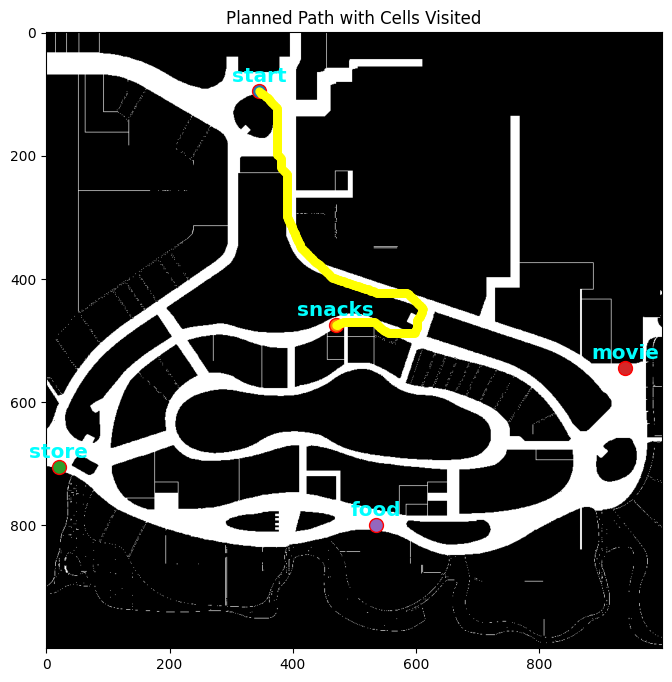

In [11]:
import time

# Implementing A* algorithm
def heuristic_cost_estimate(start, goal):
    return np.sqrt((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2) * MAP_RES

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    return total_path

def a_star(start, goal):
    # 初始化open_set，包含起点
    open_set = {start}
    # 记录每个节点的父节点
    came_from = {}
    # 记录从起点到每个节点的实际代价
    g_score = {start: 0}
    # 记录从起点到每个节点的估计总代价
    f_score = {start: heuristic_cost_estimate(start, goal)}
    
    # 记录访问的单元格数量
    visited_cells = 0

    while open_set:
        # 选择f_score最小的节点作为当前节点
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            # 如果当前节点是目标节点，则返回重构的路径、总代价和访问的单元格数量
            return reconstruct_path(came_from, goal), g_score[goal], visited_cells

        # 从open_set中移除当前节点
        open_set.remove(current)
        # 遍历当前节点的所有邻居
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                neighbor = (current[0] + dx, current[1] + dy)
                # 检查邻居是否在地图范围内
                if not (0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]):
                    continue

                # 检查邻居是否为空闲
                if grid_map[neighbor[0], neighbor[1]] != 255:
                    continue
                
                visited_cells += 1  # 增加访问的单元格数量

                # 计算从当前节点到邻居节点的代价
                if dx == 0 or dy == 0:
                    cost = 0.2  # 水平或垂直移动的代价
                else:
                    cost = 0.282  # 对角线移动的代价

                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    # 更新邻居节点的代价和父节点
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic_cost_estimate(neighbor, goal)
                    if neighbor not in open_set:
                        # 如果邻居节点不在open_set中，则添加进去
                        open_set.add(neighbor)

    # 如果没有找到路径，则返回空路径、无穷大的距离和访问的单元格数量
    return None, float('inf'), visited_cells

# Finding path from start to store
start_time = time.time()
path, total_distance, visited_cells = a_star(tuple(locations['start']), tuple(locations['snacks']))
end_time = time.time()
#print("Planned Path:", path)
print("Total Travelled Distance:", round(total_distance,3), "m")
print("Total Run Time:", end_time - start_time, "seconds")
print("Number of cells visited by A* algorithm:", visited_cells)
#print("Number of nodes in the planned path:", len(path))

# Visualize the planned path and cells visited
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='yellow', markersize=5, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()


 Implement Dijkstra

Total Travelled Distance: 140.882 m
Total Run Time: 2.3405649662017822 seconds
Number of cells visited by Dijkstra algorithm: 621445


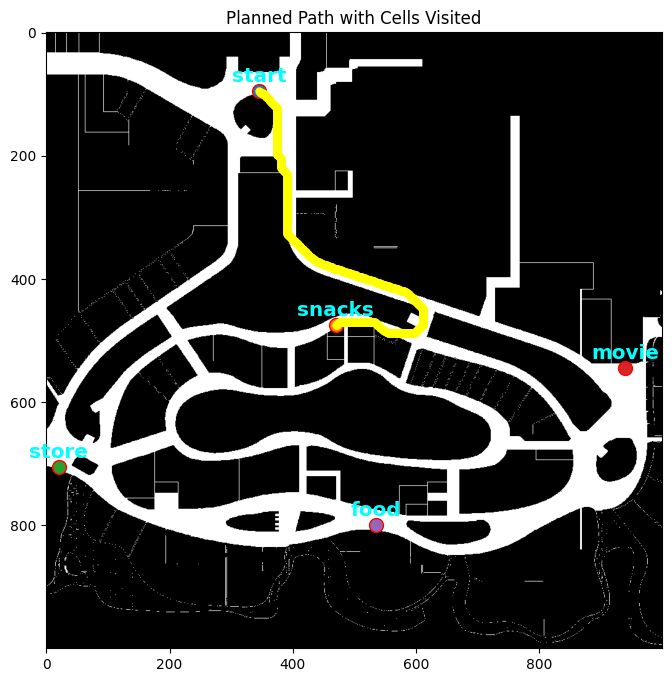

In [12]:
def dijkstra(start, goal):
    """
    Dijkstra算法：寻找从起点到目标点的最短路径。

    参数：
    - start: 元组，起点的坐标 (x, y)
    - goal: 元组，目标点的坐标 (x, y)

    返回：
    - 如果找到路径，返回路径和总距离；否则返回None和无穷大的距离
    """
    # 初始化open_set，包含起点
    open_set = {start}
    # 记录每个节点的父节点
    came_from = {}
    # 记录从起点到每个节点的实际代价
    g_score = {start: 0}
    # 记录访问的单元格数量
    visited_cells = 0

    while open_set:
        # 选择g_score最小的节点作为当前节点
        current = min(open_set, key=lambda x: g_score[x])
        if current == goal:
            # 如果当前节点是目标节点，则返回重构的路径和总代价
            return reconstruct_path(came_from, goal), g_score[goal], visited_cells

        # 从open_set中移除当前节点
        open_set.remove(current)
        # 遍历当前节点的所有邻居
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                neighbor = (current[0] + dx, current[1] + dy)
                # 检查邻居是否在地图范围内
                if not (0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]):
                    continue

                # 检查邻居是否为空闲
                if grid_map[neighbor[0], neighbor[1]] != 255:
                    continue

                visited_cells += 1  # 增加访问的单元格数量

                # 计算从当前节点到邻居节点的代价
                if dx == 0 or dy == 0:
                    cost = 0.2  # 水平或垂直移动的代价
                else:
                    cost = 0.282  # 对角线移动的代价

                tentative_g_score = g_score[current] + cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    # 更新邻居节点的代价和父节点
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    if neighbor not in open_set:
                        # 如果邻居节点不在open_set中，则添加进去
                        open_set.add(neighbor)

    # 如果没有找到路径，则返回空路径和无穷大的距离
    return None, float('inf'), visited_cells

# Finding path from start to store
start_time = time.time()
path, total_distance, visited_cells = dijkstra(tuple(locations['start']), tuple(locations['snacks']))
end_time = time.time()
#print("Planned Path:", path)
print("Total Travelled Distance:", round(total_distance, 3), "m")
print("Total Run Time:", end_time - start_time, "seconds")
print("Number of cells visited by Dijkstra algorithm:", visited_cells)  # 打印访问的单元格数量
#print("Number of nodes in the planned path:", len(path))
# Visualize the planned path and cells visited
plt.figure(figsize=(8, 8))
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, marker='o', color='yellow', markersize=5, linestyle='-')
plt.title('Planned Path with Cells Visited')
plt.show()


## Task 2